# Projeto Análise de Fraude do curso ciência de dados da hashtag

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import (
    MinMaxScaler,
    PowerTransformer,
    RobustScaler,
)


# classificador referência
from sklearn.dummy import DummyClassifier

# estudo lineares
from sklearn.linear_model import LogisticRegression

# estudo árvores
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from xgboost import plot_importance

# estudo SVM
from sklearn.svm import SVC

# estudo kNN
from sklearn.neighbors import KNeighborsClassifier

from src.auxiliares import dataframe_coeficientes
from src.config import DADOS_TRATADOS
from src.graficos import plot_comparar_metricas_modelos, plot_coeficientes
from src.models import RANDOM_STATE
from src.models import (
    grid_search_cv_classificador,
    treinar_e_validar_modelo_classificacao,
    organiza_resultados,
)

sns.set_theme(palette="bright")

In [2]:
df = pd.read_parquet(DADOS_TRATADOS)

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V19,V20,V21,V23,V24,V26,V27,V28,Amount,Class
0,41558.0,1.161641,-1.109605,0.835926,-0.588833,-1.572183,-0.278266,-1.105404,0.149678,-0.146100,...,-0.152117,0.123291,0.441826,-0.128718,0.073727,-0.022856,0.026179,0.033807,99.00,0
1,44328.0,-2.782534,-1.478002,1.878356,-0.218030,-0.355298,-0.242499,0.251224,-0.312750,-0.548804,...,-1.247148,-0.966057,-0.386752,-0.958122,0.357559,-0.458944,-0.927209,-0.485878,153.50,0
2,35528.0,1.109213,-0.010754,1.276426,1.283977,-0.708444,0.293546,-0.571341,0.174502,0.740958,...,-0.576584,-0.102363,-0.023261,0.013138,0.111150,-0.382864,0.095178,0.037120,9.99,0
3,167386.0,-0.080062,1.194406,-0.550803,-0.619168,0.940634,-0.807962,0.943133,-0.092361,0.152905,...,-0.216118,0.144212,-0.380743,0.085453,0.469797,0.123858,0.331455,0.142413,1.79,0
4,168790.0,-1.036358,0.292858,1.370509,-0.861955,0.284137,-0.742404,0.072177,0.052797,0.870517,...,-0.245923,0.177920,0.174098,-0.271423,-0.042487,0.112545,0.538802,0.316525,14.53,0


In [3]:
coluna_min_max = ["Time"]

coluna_power_transformer = ["Amount"]

target = ["Class"]

colunas_robust_scaler = [
    coluna for coluna in df.columns if coluna not in (
        coluna_min_max + coluna_power_transformer + target
    )
]

colunas_robust_scaler

['V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V14',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V23',
 'V24',
 'V26',
 'V27',
 'V28']

In [4]:
X = df.drop(columns=target)
y = df[target].values.ravel()

In [5]:
preprocessamento = ColumnTransformer(
    transformers=[
        ("min_max", MinMaxScaler(), coluna_min_max),
        ("robust", RobustScaler(), colunas_robust_scaler),
        ("power_transform", PowerTransformer(), coluna_power_transformer),
    ]
)

In [6]:
scale_pos_weight = np.bincount(y)[0] / np.bincount(y)[1]
scale_pos_weight

577.8760162601626

In [7]:
classificadores = {
    "DummyClassifier": {
        "preprocessor": None,
        "classificador": DummyClassifier(strategy="stratified"),
    },
    "LogisticRegression": {
        "preprocessor": preprocessamento,
        "classificador": LogisticRegression(class_weight="balanced"),
    },
    "DecisionTreeClassifier": {
        "preprocessor": None,
        "classificador": DecisionTreeClassifier(class_weight="balanced"),
    },
    "LGBMClassifier": {
        "preprocessor": None,
        "classificador": LGBMClassifier(
            random_state=RANDOM_STATE,
            n_jobs=-1,
            verbose=-1,
            scale_pos_weight=scale_pos_weight,
        ),
    },
    "XGBClassifier": {
        "preprocessor": None,
        "classificador": XGBClassifier(
            random_state=RANDOM_STATE, n_jobs=-1, scale_pos_weight=scale_pos_weight
        ),
    },
    "SVC": {
        "preprocessor": preprocessamento,
        "classificador": SVC(class_weight="balanced", cache_size=1000),
    },
    "KNeighborsClassifier": {
        "preprocessor": preprocessamento,
        "classificador": KNeighborsClassifier(),
    },
}

In [8]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [9]:
resultados = {
    nome_modelo: treinar_e_validar_modelo_classificacao(X, y, kf, **classificador)
    for nome_modelo, classificador in classificadores.items()
}

df_resultados = organiza_resultados(resultados)

df_resultados

,model,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,time_seconds
0,DummyClassifier,0.027925,0.048869,0.996436,0.504127,0.009756,0.009434,0.010101,0.499068,0.001738,0.076794
1,DummyClassifier,0.02992,0.046873,0.99677,0.499253,0.0,0.0,0.0,0.504206,0.001825,0.076793
2,DummyClassifier,0.028944,0.045878,0.996436,0.499077,0.0,0.0,0.0,0.499244,0.00172,0.074822
3,DummyClassifier,0.034925,0.044883,0.996489,0.499103,0.0,0.0,0.0,0.49898,0.00172,0.079808
4,DummyClassifier,0.026928,0.043883,0.996682,0.504293,0.010471,0.010753,0.010204,0.499305,0.00172,0.070811
5,LogisticRegression,1.265647,0.132645,0.97939,0.944302,0.132939,0.071713,0.909091,0.967678,0.706207,1.398292
6,LogisticRegression,1.512351,0.141621,0.975721,0.952547,0.117422,0.06267,0.929293,0.983967,0.706952,1.653971
7,LogisticRegression,1.383143,0.113698,0.976967,0.937531,0.11828,0.063309,0.897959,0.979513,0.801983,1.49684
8,LogisticRegression,1.320471,0.125665,0.976352,0.94741,0.117878,0.062981,0.918367,0.981197,0.724325,1.446136
9,LogisticRegression,1.18689,0.141622,0.97802,0.948245,0.125698,0.067466,0.918367,0.979332,0.773085,1.328512


In [10]:
df_resultados.groupby("model").mean().sort_values("test_average_precision")

,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,time_seconds
model,,,,,,,,,,
DummyClassifier,0.029729,0.046077,0.996563,0.501171,0.004045,0.004037,0.004061,0.500161,0.001745,0.075806
LGBMClassifier,1.215483,0.212701,0.967469,0.909654,0.095853,0.051234,0.851639,0.896489,0.045113,1.428183
SVC,205.82836,90.754512,0.993757,0.865931,0.293837,0.184219,0.737662,0.967691,0.430751,296.582872
DecisionTreeClassifier,8.623699,0.061608,0.99914,0.865582,0.745661,0.76292,0.731561,0.865582,0.557802,8.685307
LogisticRegression,1.3337,0.13105,0.97729,0.946007,0.122443,0.065628,0.914616,0.978337,0.74251,1.46475
KNeighborsClassifier,0.587492,24.877769,0.999445,0.867803,0.820428,0.928466,0.735704,0.915461,0.789328,25.465261
XGBClassifier,1.116038,0.192008,0.999575,0.908459,0.869016,0.928698,0.817027,0.978375,0.858104,1.308046


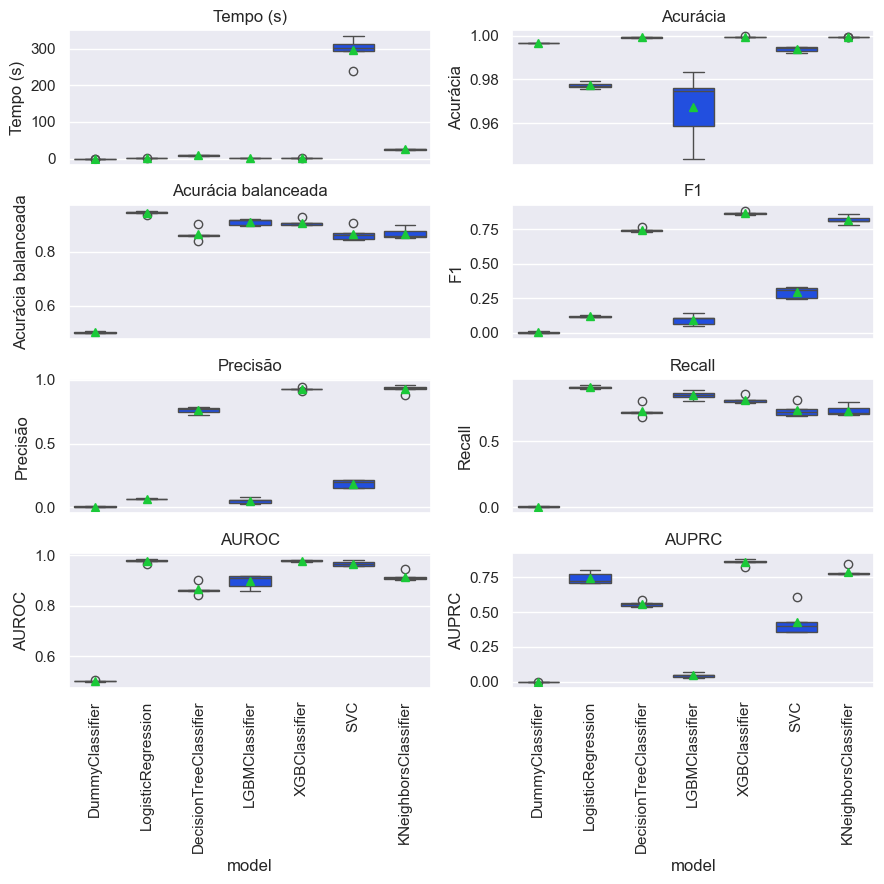

In [11]:
plot_comparar_metricas_modelos(df_resultados)